In [2]:
import pandas as pd # used to load individual files
import numpy as np # not currently used
import datetime as dt # not currently used
#from geopy.distance import geodesic might be used at some point
#import peartree as pt # used to construct network
import matplotlib.pyplot as plt
import osmnx as ox # visualisation library for networks
%matplotlib inline
import pickle
import networkx as nx
import geopandas as gp
from collections import defaultdict
from geopy.distance import geodesic
from tqdm import tqdm
from sklearn.neighbors import BallTree
import math

/opt/conda/lib/python3.10/site-packages/osmnx/projection.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [3]:
with open('rejsekort_graph_cleaned.gpickle', 'rb') as f:
    G = pickle.load(f)

# Relabels nodes by removing WPDOS_ from each node
# relabel_dic = {node:node[6:] for node in G.nodes()}
# G = nx.relabel_nodes(G, relabel_dic, copy=False)



In [4]:
print(nx.number_weakly_connected_components(G))


30


In [25]:
len(ccs[1])

13456

In [37]:
# for edge in G.edges():
#     edge = G.get_edge_data(*edge)
#     print(edge)


In [5]:
set_unknown = set()
with open("data/transfers.txt") as f:
    transfers = pd.read_csv(f, sep=",",dtype=str)
    for idx in range(len(transfers)):
        line = transfers.iloc[idx]
        node1 = line.from_stop_id
        node2 = line.to_stop_id
        length = line.min_transfer_time
        if node1 not in G.nodes():
            set_unknown.add(node1)
        if node2 not in G.nodes():
            set_unknown.add(node2)    
        # G.add_edge(node1, node2, mode = 'transfer', length=length)

print(len(node2))

12


In [6]:
list(set_unknown)[2]

'000835000402'

In [7]:
len(set_unknown)

261

In [8]:
len(G.nodes())
len(G.edges)

52656

/opt/conda/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/opt/conda/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


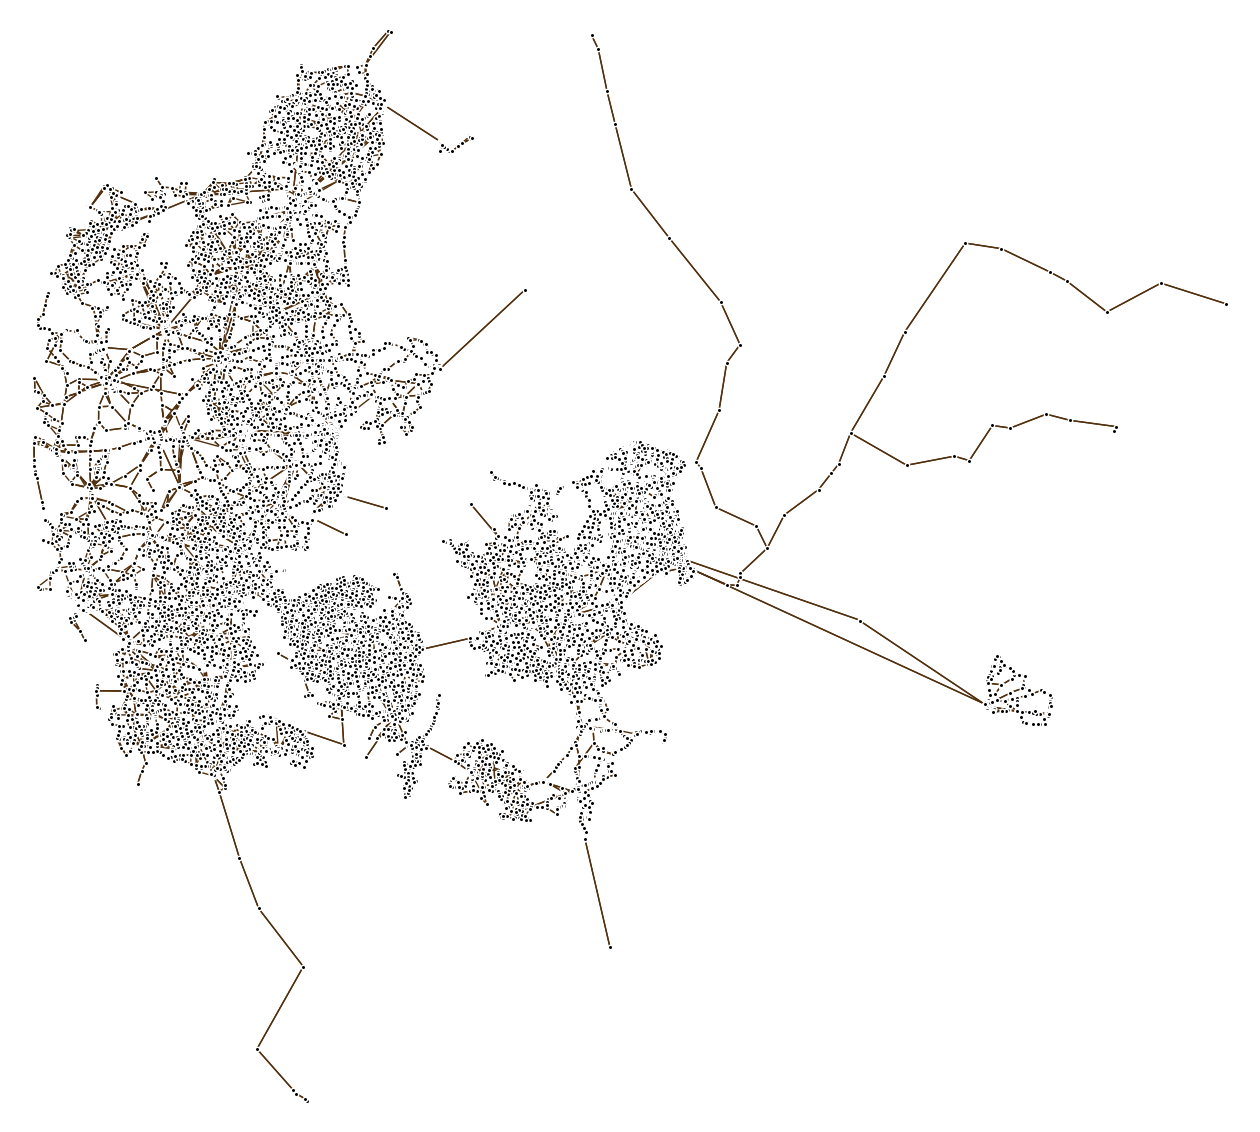

In [10]:
fig, ax = ox.plot_graph(G,
               figsize = (16,16),
                show=False,
                close=False,
                node_color='black',
                node_edgecolor="white",
                node_size=10,
                node_zorder=10,
                edge_color='#522F0D',
                edge_alpha=1,
                edge_linewidth = 1,
                bgcolor='None',
                #bbox= bbox_,
               #bgcolor='black'
              
             );

Modes of transport from GTFS reference
109 s-tog
700 bus
715 demand and response bus service
0 letbanen lightrail
1 is metro
2 train/intercity
3 localtog and bus?
4 ferry maybe other too?

Types of busses
S bus is fast and direct bus routes
e bus are express buslines during rush hour
p bus are local buses
n bus are night buses
havn bus




In [11]:
modes= [G.nodes[node]["modes"] for node in G.nodes()]
uniqmodes = set()
for mode in modes:
    uniqmodes = uniqmodes.union(set(mode))
uniqmodes

{'0', '1', '109', '2', '3', '4', '700', '715'}

In [12]:
edges = G.edges()

In [14]:
G.nodes()['000000000002']

{'boarding_cost': 1681.8,
 'modes': ['3'],
 'y': 55.767248497366,
 'x': 12.498017540594}

In [15]:
G['000000000002']

AdjacencyView({'000000000003': {0: {'length': 60.0, 'mode': 'transit'}}})

In [16]:
mode_counts=defaultdict(int)
for edge in G.edges():
    edge = G.get_edge_data(*edge)
    mode_counts[edge[0]['mode']] += 1
print(mode_counts)

defaultdict(<class 'int'>, {'transit': 52656})


In [38]:
def tacicab_sphere(latlong1,latlong2):
    '''
    Returns the taxicab distance between two points on a sphere (given lat-long pairs).
    Formula: http://cs.ucmo.edu/~mjms/2005.1/bayar.pdf
    '''
    x1,y1 = latlong1
    x2,y2 = latlong2
    return min(
        geodesic((x1,y1),(x2,y1)).meters + geodesic((x2,y1),(x2,y2)).meters,
        geodesic((x1,y1),(x1,y2)).meters + geodesic((x1,y2),(x2,y2)).meters
    )

def m2s(m):
    return m/1.25 #Walking speed used by Google Maps

# Conversion function for input to BallTree
def convert_latlon_to_balltree_input(lat, lon):
    return np.vstack([np.radians(lon), np.radians(90-np.array(lat))]).T

In [18]:
''' Bad Code
def add_walk_edges(G):
    G = G.copy()
    for node1 in tqdm(G.nodes()):
        for node2 in G.nodes():
            if node1 == node2:
                continue
            for (u,v,edge_type) in G.edges(node1, data="mode"):
                if v == node2 and edge_type in {"transfer","walk"}:
                    break
            else:
                walk_time = m2s(tacicab_sphere((G.nodes[node1]["x"],G.nodes[node1]["y"]),(G.nodes[node2]["x"],G.nodes[node2]["y"])))
                if walk_time <= 30*60 or node2 in G.neighbors(node1): #If less than x time away or transit edge (non-walk, non-transfer neigbor-edges)
                    G.add_edge(node1, node2, routes = {}, trips = {}, mode = 'walk', weight=max(walk_time,180))
    return G.
'''

In [40]:
# Good code
def add_walk_edges(G):
    G = G.copy()
    node_positions = convert_latlon_to_balltree_input([G.nodes[node]["y"] for node in G.nodes()], [G.nodes[node]["x"] for node in G.nodes()])
    balltree = BallTree(node_positions, metric='haversine')

    for idx1, node1 in enumerate(tqdm(G.nodes())):
        node1_position = convert_latlon_to_balltree_input([G.nodes[node1]["y"]], [G.nodes[node1]["x"]])
        
        # Use the BallTree to find all nodes within 1 km
        # Divide by the Earth's radius, which is approximately 6371 kilometres, to convert to radians
        close_nodes = balltree.query_radius(node1_position, r=1.0 / 6371)
        close_nodes = close_nodes[0]  # query_radius returns a list of arrays, we are interested in the first array

        for idx2 in close_nodes:
            node2 = list(G.nodes())[idx2]
            if node1 == node2:
                continue
            for (u,v,edge_type) in G.edges(node1, data="mode"):
                if v == node2 and edge_type in {"transfer","walk"}:
                    break
            else:
                walk_time = m2s(tacicab_sphere((G.nodes[node1]["x"],G.nodes[node1]["y"]),(G.nodes[node2]["x"],G.nodes[node2]["y"])))
                if walk_time <= 30*60 or node2 in G.neighbors(node1): #If less than x time away or transit edge (non-walk, non-transfer neigbor-edges)
                    G.add_edge(node1, node2, routes = {}, trips = {}, mode = 'walk', weight=max(walk_time,180))
    return G

In [41]:
#G_walks = add_walk_edges(G)

100%|█████████████████████████████████████████████████████████████████████████████| 38172/38172 [15:40<00:00, 40.61it/s]


In [53]:
#with open('G_walks.pkl', 'wb') as file:
#    pickle.dump(G_walks, file)

In [3]:
with open('G_walks.pkl', 'rb') as f:
    G_walks = pickle.load(f)

In [42]:
ccs = [c for c in sorted(nx.weakly_connected_components(G_walks), key=len, reverse=True)]

In [4]:
relabel_dic = {node:int(node) for node in G_walks.nodes()}
nx.relabel_nodes(G_walks, relabel_dic, copy=False)

In [5]:
df = pd.read_csv('data/jan_2019.csv', encoding = 'unicode_escape')

In [6]:
# We want all unique stop ids so we can merge them to the stops.txt, which has some discrepancies
start_ids = df[["StartStopPointNr", "StartSite"]].rename(columns={"StartStopPointNr": "stop_id", "StartSite": "stop_name"})
slut_ids = df[["SlutStopPointNr", "SlutSite"]].rename(columns={"SlutStopPointNr": "stop_id", "SlutSite": "stop_name"})
stop_ids = pd.concat([start_ids, slut_ids]).drop_duplicates()
stop_ids.stop_name = stop_ids.stop_name.str.lower() # removing uppercase for better merging
#stop_ids.set_index('stop_id', inplace=True)
id2name = pd.Series(stop_ids.stop_name.values,index=stop_ids.stop_id).to_dict()

In [7]:
check_in = df.groupby('StartStopPointNr').sum('SUM_of_Personrejser')
check_ud = df.groupby('SlutStopPointNr').sum('SUM_of_Personrejser')

In [8]:
stops = pd.read_csv('data/stops.txt')
stops.stop_name = stops.stop_name.str.lower() # removing uppercase for better merging
#stops.set_index('stop_id', inplace=True)
stops_id2name = pd.Series(stops.stop_name.values,index=stops.stop_id).to_dict()

for key, value in stops_id2name.items():
    id2name.setdefault(key, value)

In [9]:
#creating dictionary that maps ids in the jan_2019.csv to ids in stops.txt by station name
all_stops = pd.merge(stops.drop(columns=["stop_code", "stop_desc", "stop_lat", "stop_lon", "location_type", "parent_station", "wheelchair_boarding", "platform_code"]), stop_ids, on='stop_name')
incorrectid2correctid = all_stops.set_index('stop_id_y')['stop_id_x'].to_dict()

In [371]:
#check_missing = [isinstance(index, int) for index in index_values]

2236

In [10]:
check_in_named = check_in.sort_values(by='SUM_of_Personrejser', ascending=False).rename(index=id2name)
check_ud_named = check_ud.sort_values(by='SUM_of_Personrejser', ascending=False).rename(index=id2name)

In [11]:
df1 = check_in.reset_index().rename(columns = {'StartStopPointNr': 'stop_id', 'SUM_of_Personrejser': 'weight'}).drop(['RejseUge','SlutStopPointNr'], axis=1)
df2 = check_ud.reset_index().rename(columns = {'SlutStopPointNr': 'stop_id', 'SUM_of_Personrejser': 'weight'}).drop(['RejseUge', 'StartStopPointNr'], axis=1)
weight_df = pd.concat([df1, df2]).groupby('stop_id').sum()

In [12]:
weight_df = weight_df.rename(index = incorrectid2correctid) # Using stop_id given by stop.txt
weight_df = weight_df.groupby('stop_id').sum() # Coalescing all stop_ids with the same station

missing_ids = []
for id in weight_df.index:
    if not id in G_walks.nodes():
        missing_ids.append(id)
print(len(missing_ids))

2325


In [13]:
# 1.5% of stations (by number of passengers) are missing
missing_ratio = int(weight_df.loc[missing_ids].sum())/int(weight_df.sum())
print(f'{round(100*len(weight_df.loc[missing_ids])/len(weight_df),2)}% of stations are missing')
print(f'They account for {round(100*missing_ratio,2)}% of traffic')

8.04% of stations are missing
They account for 1.57% of traffic


In [14]:
print('Top 20 missing stations')
weight_df.loc[missing_ids].sort_values('weight', ascending=False).rename(index=id2name).head(20)

Top 20 missing stations


,weight
stop_id,
trianglen,27494.0
fr.borggade/farimagsgade,13761.0
amalienborg,10984.0
østre allé (bornholmsgade / aalborg),10566.0
østre allé (bornholmsgade / aalborg),9479.0
trianglen,8658.0
zoneskifte 1/2,8597.0
"rigshospitalet, glostrup",8053.0
zoneskifte 5/1,7919.0


In [15]:
clean_df = weight_df.drop(missing_ids)

In [588]:
clean_df

,weight
stop_id,
2,146.0
6,4308.0
8,1856.0
11,8585.0
12,3753.0
...,...
861200402,6.0
861200502,149.0
861200701,4.0


In [16]:
# Adding weights to nodes according to jan 2019 usage data
for key, weight in clean_df.iterrows():
    G_walks.nodes()[key]['weight'] = weight

/opt/conda/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/opt/conda/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


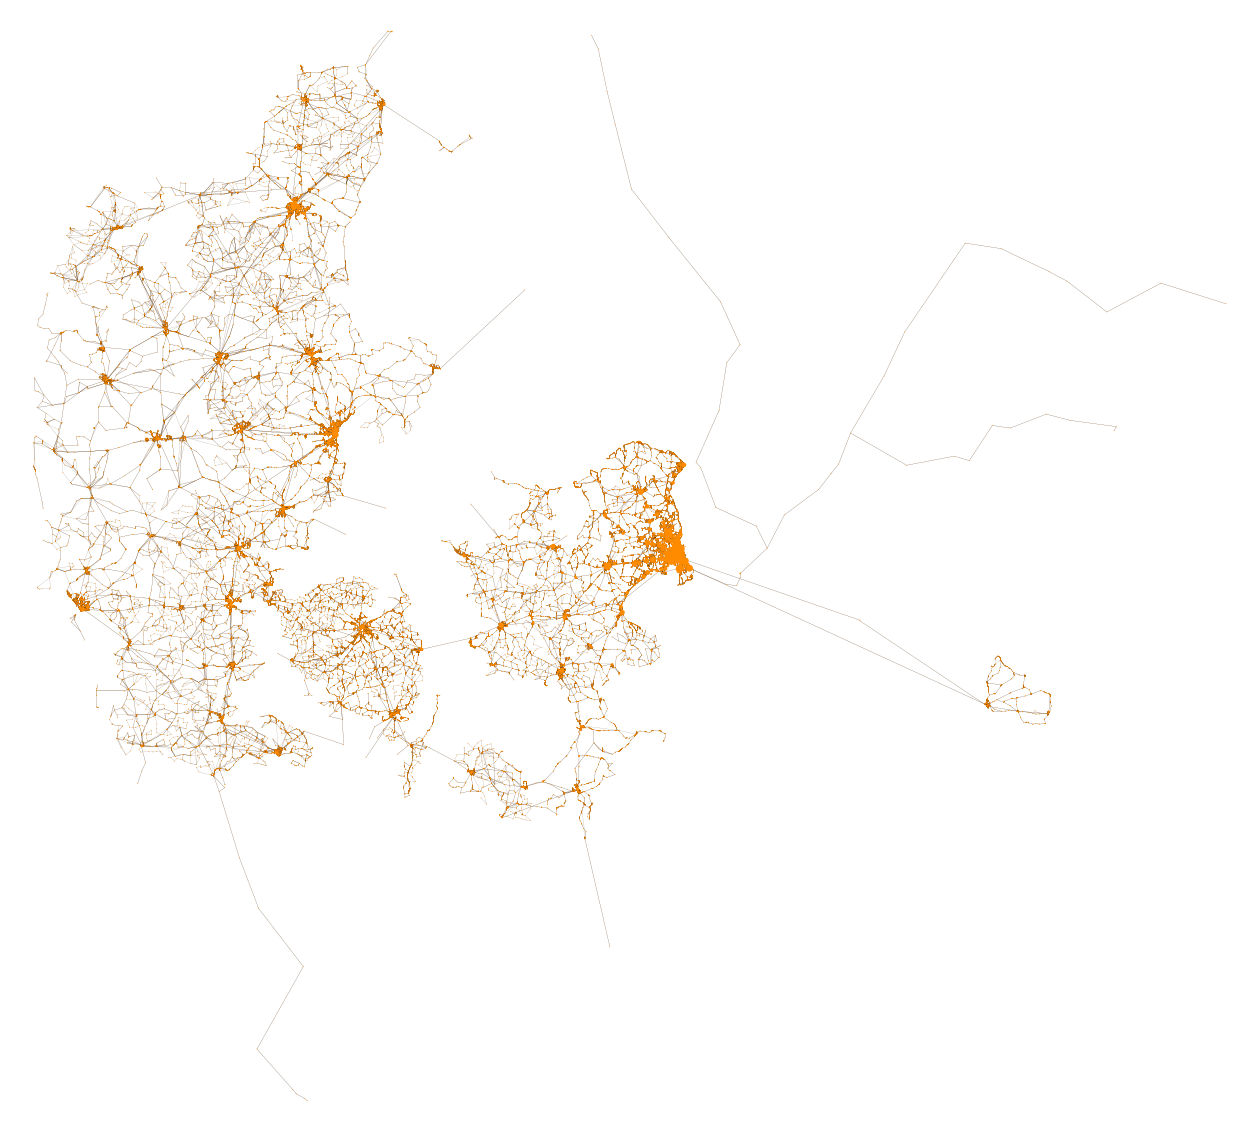

In [55]:
# Get a list of node weights and give nodes without weight a 0
node_weights = [int(data.get('weight', 0)) for _, data in G_walks.nodes(data=True)]
node_weights = pd.Series(node_weights) #osmnx expects pandas Series

# Normalize weights to a reasonable range for plotting, add a constant to show less travelled nodes
normalized_weights = ((3000+node_weights)-node_weights.mean())/node_weights.std()

fig, ax = ox.plot_graph(G_walks,
               figsize = (16,16),
                show=False,
                close=False,
                node_color='darkorange',
                #node_edgecolor="white",
                node_size=normalized_weights,
                node_zorder=10,
                edge_color='#522F0D',
                edge_alpha=0.8,
                edge_linewidth = 0.1,
                bgcolor='None',
                #bbox= bbox_,
               #bgcolor='black'
              
             );